In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from surprise import CoClustering
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold,GridSearchCV

In [2]:
# Data
df = pd.read_csv("data/full_data_cleaned.csv")
df.head()

,author_id,rating_x,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,review_title,...,price_usd_x,brand_id,ingredients,limited_edition,out_of_stock,sephora_exclusive,highlights,primary_category,num_rating,niche_product
0,1238130325,4,1.0,NaN,0,0,0,3/12/23,I love this lippy…it makes my lips soft and al...,Yumm,...,24.0,6125,"['Diisostearyl Malate, Hydrogenated Polyisobut...",0,0,1,"['allure 2019 Best of Beauty Award Winner', 'C...",Skincare,1227,0
1,27991208736,3,1.0,0.0,1,1,0,3/9/23,ive tried my friend’s a few times and it does ...,overrated/overpriced,...,24.0,6125,"['Diisostearyl Malate, Hydrogenated Polyisobut...",0,0,1,"['allure 2019 Best of Beauty Award Winner', 'C...",Skincare,1227,0
2,9467587295,5,1.0,0.5,2,1,1,3/7/23,This product is a DEFINITE must for chapped li...,Life saver,...,24.0,6125,"['Diisostearyl Malate, Hydrogenated Polyisobut...",0,0,1,"['allure 2019 Best of Beauty Award Winner', 'C...",Skincare,1227,0
3,12367701277,5,1.0,NaN,0,0,0,3/5/23,Love this lip masks so much I bought so many o...,Love 💗,...,24.0,6125,"['Diisostearyl Malate, Hydrogenated Polyisobut...",0,0,1,"['allure 2019 Best of Beauty Award Winner', 'C...",Skincare,1227,0
4,33161024868,3,0.0,1.0,1,0,1,3/4/23,I don’t see the hype for this product. It does...,Works every once in a while,...,24.0,6125,"['Diisostearyl Malate, Hydrogenated Polyisobut...",0,0,1,"['allure 2019 Best of Beauty Award Winner', 'C...",Skincare,1227,0


In [3]:
# Select related columns
rating_df = df[['author_id', 'product_id', 'rating_x']]
rating_df.head()

,author_id,product_id,rating_x
0,1238130325,P420652,4
1,27991208736,P420652,3
2,9467587295,P420652,5
3,12367701277,P420652,5
4,33161024868,P420652,3


In [4]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424374 entries, 0 to 424373
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   author_id   424374 non-null  object
 1   product_id  424374 non-null  object
 2   rating_x    424374 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 9.7+ MB


In [5]:
# Set up data
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(rating_df[['author_id', 'product_id', 'rating_x']], reader)

In [6]:
# Set up possible values of hyperparameter
param_grid = {
    'n_cltr_u': [1,2,3,4,5],
    'n_cltr_i': [1,2,3,4,5], 
    'n_epochs': [10,20,30,40,50],
    'random_state': [2024]
}

In [9]:
# setting up for grid search
gs = GridSearchCV(CoClustering,
                 param_grid,
                 measures=['rmse', 'mae', 'fcp'],
                 cv=KFold(n_splits = 5, random_state = 2024))

In [10]:
# fit data to model
gs.fit(data)

In [11]:
# Convert list of parameters to DataFrame
results_df = pd.DataFrame(gs.cv_results['params'])

# Add new columns to the dataframe
results_df['rmse'] = gs.cv_results['mean_test_rmse']
results_df['mae'] = gs.cv_results['mean_test_mae']
results_df['fcp'] = gs.cv_results['mean_test_fcp']

# View result dataframe
results_df

,n_cltr_u,n_cltr_i,n_epochs,random_state,rmse,mae,fcp
0,1,1,10,2024,0.993155,0.628796,0.497762
1,1,1,20,2024,0.993155,0.628796,0.497762
2,1,1,30,2024,0.993155,0.628796,0.497762
3,1,1,40,2024,0.993155,0.628796,0.497762
4,1,1,50,2024,0.993155,0.628796,0.497762
...,...,...,...,...,...,...,...
120,5,5,10,2024,1.040090,0.640010,0.496361
121,5,5,20,2024,1.067030,0.656356,0.497788
122,5,5,30,2024,1.083222,0.666200,0.498894
123,5,5,40,2024,1.104049,0.679106,0.500450


In [12]:
# save data to local folder
results_df.to_csv(path_or_buf='Coclustering_hyperparam_result.csv', index=False)

In [13]:
# extract best set of hyperparameter per each
print('Best ranking (FCP):', gs.best_score['fcp'])
print('Best parameters for ranking (FCP):', gs.best_params['fcp'])

print('Best MAE:', gs.best_score['mae'])
print('Best parameters for MAE:', gs.best_params['mae'])

print('Best RMSE:', gs.best_score['rmse'])
print('Best parameters for RMSE:', gs.best_params['rmse'])

Best ranking (FCP): 0.5111502237915337
Best parameters for ranking (FCP): {'n_cltr_u': 3, 'n_cltr_i': 5, 'n_epochs': 10, 'random_state': 2024}
Best MAE: 0.6227862719091783
Best parameters for MAE: {'n_cltr_u': 2, 'n_cltr_i': 4, 'n_epochs': 10, 'random_state': 2024}
Best RMSE: 0.9906664735755312
Best parameters for RMSE: {'n_cltr_u': 2, 'n_cltr_i': 4, 'n_epochs': 10, 'random_state': 2024}


# Visualization

In [14]:
# Suppress SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

# Extract row for best sets of hyperparameters
best_params_df = results_df.query(
    "(n_cltr_u == 3 and n_cltr_i == 5 and n_epochs == 10) or "
    "(n_cltr_u == 2 and n_cltr_i == 4 and n_epochs == 10)"
)

best_params_df.loc[:, 'set']=[1,2]
best_params_df

,n_cltr_u,n_cltr_i,n_epochs,random_state,rmse,mae,fcp,set
40,2,4,10,2024,0.990666,0.622786,0.504411,1
70,3,5,10,2024,1.021815,0.634889,0.511150,2


In [15]:
# convert to long format
best_params_df_long = best_params_df[['rmse','mae','fcp','set']].melt('set', var_name='metric', value_name='values')
# Display DataFrame
best_params_df_long

,set,metric,values
0,1,rmse,0.990666
1,2,rmse,1.021815
2,1,mae,0.622786
3,2,mae,0.634889
4,1,fcp,0.504411
5,2,fcp,0.511150


In [16]:
# write a function to calculate the average of cross-validation evaluation metrics
# and convert the dataframe from wide to long format for further plotting
def results_sum_func(param):
    grouped_df = results_df.groupby(param)[['rmse', 'mae', 'fcp']].mean()
    grouped_df_long = grouped_df.reset_index().melt(param, var_name='metric', value_name='values')
    return grouped_df_long

In [17]:
# run function for 5 parameters
grouped_results_df1 = results_sum_func('n_cltr_u')
grouped_results_df2 = results_sum_func('n_cltr_i')
grouped_results_df3 = results_sum_func('n_epochs')

In [18]:
# view one long dataframe to check the result
grouped_results_df1

,n_cltr_u,metric,values
0,1,rmse,0.993155
1,2,rmse,0.997024
2,3,rmse,1.019777
3,4,rmse,1.036506
4,5,rmse,1.045845
5,1,mae,0.628796
6,2,mae,0.627378
7,3,mae,0.637550
8,4,mae,0.647093
9,5,mae,0.651003


In [19]:
# create function to draw each subplot
def subplot_func(long_df, param, row, col, fig_num, xlabel, ylabel):
    # Convert parameter column to string for better display of comparision on plot
    long_df[param] = long_df[param].astype(str)
    # Plot lines
    for metric in long_df['metric'].unique():
        data = long_df[long_df['metric'] == metric]
        ax[row,col].plot(data[param], data['values'], label=f'{metric}')
    # Set title and labels
    ax[row,col].set_title('Figure '+fig_num+': '+'Metrics comparision based on'+' '+param)
    ax[row,col].set_xlabel(xlabel)
    ax[row,col].set_ylabel(ylabel)
    # Add legend to the plot
    ax[row,col].legend()

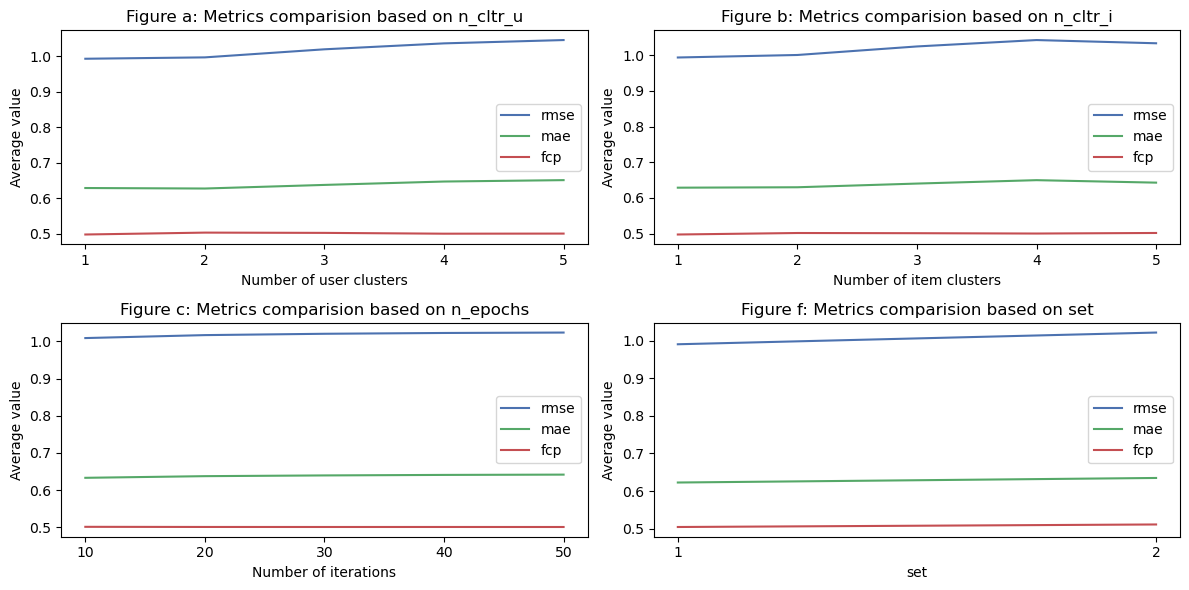

In [20]:
plt.style.use("seaborn-v0_8-deep")
# Create structure for the big plot
fig, ax = plt.subplots(2,2, figsize=(12, 6))

## Subplot 1
subplot_func(grouped_results_df1, 'n_cltr_u', 0, 0, 
             'a', 'Number of user clusters', 'Average value')
## Subplot 2
subplot_func(grouped_results_df2, 'n_cltr_i', 0, 1, 
             'b', 'Number of item clusters', 'Average value')

## Subplot 3
subplot_func(grouped_results_df3, 'n_epochs', 1, 0, 
             'c', 'Number of iterations', 'Average value')

## Subplot 6
subplot_func(best_params_df_long, 'set', 1, 1, 
             'f', 'set', 'Average value')

plt.tight_layout()  # Adjust the layout to prevent overlaps
plt.savefig('CF_model_coclustering.png', dpi=900)
plt.show()